In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.color import rgb2gray
from skimage.io import imread
import scipy.fftpack as fp
from scipy import signal
import scipy.misc
from imageio import imread

import psychopy.visual
import psychopy.event
import psychopy.filters

In [2]:
def filter(nx,ny, d0,d1):
    fil = np.ones((nx,ny))
    for i in range(nx):
        for j in range(ny):
            dist = np.sqrt((i-nx/2)**2 + (j-ny/2)**2)
            fil[i+1,j+1] = np.multipy(np.exp(-(dist**2)/(d1**2)), (1.0-np.exp(-(dist**2)/(d0**2))))
    fil[nx/2+1,ny/2+1] = 1
    return fil
                                      

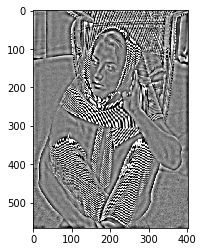

In [4]:
def drawing_like(source, rms = 0.5):
    # this gives a (y, x) array of values between 0.0 and 255.0
    raw_img = imread(
        source
        #'barbara.tif',
    )
    temp = raw_img

    # we first need to convert it to the -1:+1 range
    raw_img = (raw_img / 255.0) * 2.0 - 1.0

    # we also need to flip it upside-down to match the psychopy convention
    raw_img = np.flipud(raw_img)

    # desired RMS
    

    # make the mean to be zero
    raw_img = raw_img - np.mean(raw_img)
    # make the standard deviation to be 1
    raw_img = raw_img / np.std(raw_img)
    # make the standard deviation to be the desired RMS
    raw_img = raw_img * rms

    # convert to frequency domain
    img_freq = np.fft.fft2(raw_img)

    # calculate amplitude spectrum
    img_amp = np.fft.fftshift(np.abs(img_freq))

    hp_filt = psychopy.filters.butter2d_hp(#high-pass Butterworth 
        size=raw_img.shape,
        cutoff=0.05,
        n=10
    )

    img_filt = np.fft.fftshift(img_freq) * hp_filt

    # convert back to an image
    img_new = np.real(np.fft.ifft2(np.fft.ifftshift(img_filt)))

    # convert to mean zero and specified RMS contrast
    img_new = img_new - np.mean(img_new)
    img_new = img_new / np.std(img_new)
    img_new = img_new * rms

    # there may be some stray values outside of the presentable range; convert < -1
    # to -1 and > 1 to 1
    img_new = np.clip(img_new, a_min=-1.0, a_max=1.0)
    if(rms != 0):
        return np.flipud(img_new)
    else:
        return temp
    
plt.imshow(drawing_like('barbara.tif'), cmap = 'gray')

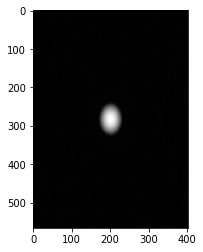

<Figure size 720x720 with 0 Axes>

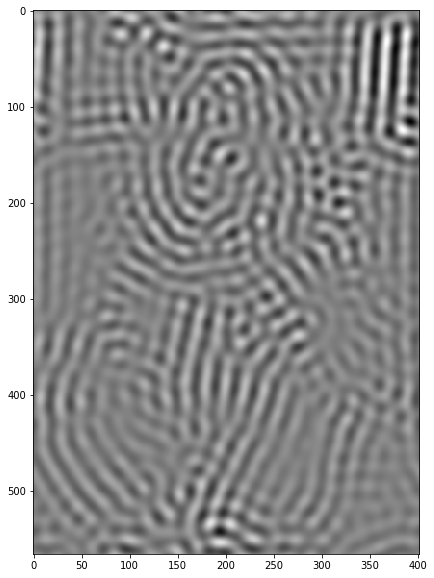

In [5]:
def freq_img_filt(source, blur_val = 10, line_like_val = 0.01):
    #im = rgb2gray(imread(source))#'barbara.tif'
    im = drawing_like('barbara.tif', line_like_val)
    kernel = np.outer(signal.gaussian(im.shape[0], blur_val), signal.gaussian(im.shape[1], blur_val))
    freq = fp.fft2(im)
    assert(freq.shape == kernel.shape)
    freq_kernel = fp.fft2(fp.ifftshift(kernel))
    convolved = freq*freq_kernel # by the Convolution theorem
    im_blur = fp.ifft2(convolved).real
    im_blur = 255 * im_blur / np.max(im_blur)

    # center the frequency response
    plt.imshow( (20*np.log10( 0.01 + fp.fftshift(freq_kernel))).real.astype(int), cmap = 'gray')
    plt.figure(figsize=(10,10))
    plt.show()

    plt.figure(figsize=(10,10))
    plt.imshow(im_blur, cmap='gray')
    plt.show()
freq_img_filt('barbara.tif', 10)

In [6]:
im = cv2.imread('barbara.tif', 0)
# create the motion blur kernel
size = 21
kernel = np.zeros((size, size))
kernel[int((size-1)/2), :] = np.ones(size)
kernel = kernel / size
kernel = np.pad(kernel, (((im.shape[0]-size)//2,(im.shape[0]-size)//2+1), ((im.shape[1]-size)//2,(im.shape[1]-size)//2+1)), padwithzeros)
 
freq = fp.fft2(im)
freq_kernel = fp.fft2(fp.ifftshift(kernel))
convolved1 = freq1*freq_kernel1
im_blur = fp.ifft2(convolved1).real
im_blur = im_blur / np.max(im_blur)
 
epsilon = 10**-6
 
freq = fp.fft2(im_blur)
freq_kernel = 1 / (epsilon + freq_kernel1)
 
convolved = freq*freq_kernel
im_restored = fp.ifft2(convolved).real
im_restored = im_restored / np.max(im_restored)
 
plt.figure(figsize=(18,12))
plt.subplot(221)
plt.imshow(im)
plt.title('Original image', size=20)
plt.axis('off')
plt.subplot(222)
plt.imshow(im_blur)
plt.title('Blurred image with motion blur kernel', size=20)
plt.axis('off')
plt.subplot(223)
plt.imshow(im_restored)
plt.title('Restored image with inverse filter', size=20)
plt.axis('off')
plt.subplot(224)
plt.imshow(im_restored - im)
plt.title('Diff restored &amp;amp;amp;amp;amp;amp;amp;amp;amp;amp;amp;amp;amp; original image', size=20)
plt.axis('off')
plt.show()
 
# Plot the surface of the frequency responses here

NameError: name 'padwithzeros' is not defined

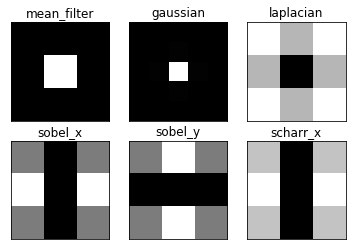

In [7]:
# simple averaging filter without scaling parameter
mean_filter = np.ones((3,3))

# creating a guassian filter
x = cv2.getGaussianKernel(5,10)
gaussian = x*x.T

# different edge detecting filters
# scharr in x-direction
scharr = np.array([[-3, 0, 3],
                   [-10,0,10],
                   [-3, 0, 3]])
# sobel in x direction
sobel_x= np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# sobel in y direction
sobel_y= np.array([[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]])
# laplacian
laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian','laplacian', 'sobel_x', \
                'sobel_y', 'scharr_x']
fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(mag_spectrum[i],cmap = 'gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])

plt.show()

(Text(0.5, 1.0, 'Magnitude Spectrum'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

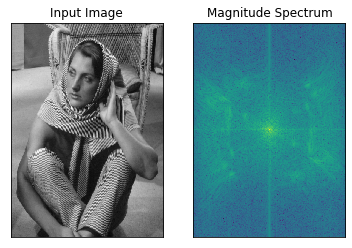

In [8]:

img = cv2.imread('barbara.tif',0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum)
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
